### Select the best pretrained model

Check the benchamarks of models here and choose the best model: https://pytorch.org/docs/stable/torchvision/models.html

In [0]:
import torchvision
from torchvision import transforms, datasets

import torch

In [2]:
model = torchvision.models.wide_resnet101_2(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth


In [0]:
def load_mnist():

    root = "./"

    # Data loading code
    normalize = transforms.Normalize(mean=(0.1307,),
                                     std=(0.3081,))

    transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor(), normalize])

    # define two datasets in order to have different transforms
    # on training and validation
    dataset_train = datasets.MNIST(root=root, train=True, transform=transform, download=True)
    dataset_test = datasets.MNIST(root=root, train=False, transform=transform, download=True)
    return dataset_train, dataset_test

In [4]:
trainset, testset = load_mnist()


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


### Load data and analyse it

In [0]:
import os

In [5]:
os.listdir("./")

['.config', 'sample_data']

In [0]:
data_dir = "challenges-in-representation-learning-facial-expression-recognition-challenge"

In [0]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
os.listdir(data_dir)

In [0]:
tar = tarfile.open(data_dir + "/fer2013.tar.gz")
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head()

In [0]:
df["Usage"].value_counts()

In [0]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.head()

In [0]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

In [0]:
test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [0]:
test_df["pixels"] = test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(test_df["pixels"].values)
y_test = np.array(test_df["emotion"])

In [0]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

In [0]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

### Create dataloaders

In [0]:
class NumpyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

trainset = NumpyDataset(images=x_train, labels=y_train)

testset = NumpyDataset(images=x_test, labels=y_test)


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [0]:
classes = []
for _, targets in trainloader:
  classes.extend(set(targets.numpy()))

In [7]:
classes = list(set(classes))
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


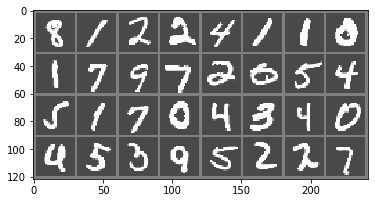

    8     1     2     2


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Create loss and optimizer

In [0]:
import torch.optim as optim
from torch import nn

In [0]:
model.fc = nn.Linear(in_features=2048, out_features=len(classes), bias=True)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the model

In [0]:
epochs = 10

In [0]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### Save model

In [0]:
torch.save(model.state_dict(), PATH)

### Test

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))